In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import os
import ast
import datetime as dt
from functions import vals_to_boxes as boxes
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import math

In [2]:
os.system("ls datasets/")

luftklima.csv
luftklima_avg_by_date.csv
luftklima_reformatted.csv
strassen.csv
verkehrszählungen_total_per_date.csv
verkehrszählungen.csv
verkehrszählungen_reformatted.csv
verkehrszählungen_reformatted_update.csv


0

### Load data sets as pd.DataFrame

In [5]:
luft = pd.read_csv("datasets/luftklima_reformatted.csv")

In [6]:
verkehr = pd.read_csv("datasets/verkehrszählungen_reformatted_update.csv")

In [7]:
sdf = pd.read_csv("datasets/strassen.csv", delimiter=";")

### Only select data from 2021/05/03 - 2021/05/09 (one week Mon through Sun)

In [8]:
df1 = luft[(luft.Datum >= "2021-05-03") & (luft.Datum <= "2021-05-09")]

In [9]:
df2 = verkehr[(verkehr.Date >= "2021-05-03") & (verkehr.Date <= "2021-05-09")]

In [10]:
df1.Datum.min()

'2021-05-03'

In [11]:
df1.Datum.max()

'2021-05-09'

In [12]:
df2.Date.min()

'2021-05-03'

In [13]:
df2.Date.max()

'2021-05-09'

### Define boundaries of map

In [14]:
os.system("ls maps/")

basel_heat_bw.png
basel_heat_test.png
basel_square.png
basel_square_bw.jpg
basel_square_coords.txt


0

In [15]:
f = open("maps/basel_square_coords.txt", "r")

In [16]:
s = f.read()

In [17]:
f.close()

In [18]:
s

'7.5554,7.6240,47.5342,47.5815\n'

In [19]:
box = [float(x) for x in s[:-1].split(",")]

In [20]:
box

[7.5554, 7.624, 47.5342, 47.5815]

In [21]:
x_min = box[0]
x_max = box[1]
y_min = box[2]
y_max = box[3]

### Extract street points from sdf

In [22]:
spoints = sdf["Geo Shape"]

In [23]:
spoints.head()

0    {"type": "LineString", "coordinates": [[7.5416...
1    {"type": "LineString", "coordinates": [[7.6288...
2    {"type": "LineString", "coordinates": [[7.6242...
3    {"type": "LineString", "coordinates": [[7.5731...
4    {"type": "LineString", "coordinates": [[7.6177...
Name: Geo Shape, dtype: object

In [24]:
# index where array begins, also not include closing "}"
start = spoints[0].find("[")
spoints = spoints.apply(lambda x: x[start:-1])

In [25]:
spoints.head()

0    [[7.541670863872596, 47.554064696108675], [7.5...
1    [[7.628899268424232, 47.529900929585], [7.6289...
2    [[7.624217938345526, 47.54084499162853], [7.62...
3    [[7.573138865961641, 47.56474766024343], [7.57...
4    [[7.617764395897929, 47.5550731092304], [7.617...
Name: Geo Shape, dtype: object

In [26]:
# define function for plotting streets
def plot_streets(zorder=0, rainbow=False, color="red", alpha=1.0):
    label="speed limit ≥ 50km/h"
    for row in spoints:
        # from string to array
        lst = ast.literal_eval(row)
        npa = np.array(lst).T
        x = npa[0, :]
        y = npa[1, :]
        
        if rainbow:
            plt.plot(x, y, zorder=zorder, alpha=alpha, label=label)
            label=None
        else:
            plt.plot(x, y, zorder=zorder, c=color, alpha=alpha, label=label)
            label=None

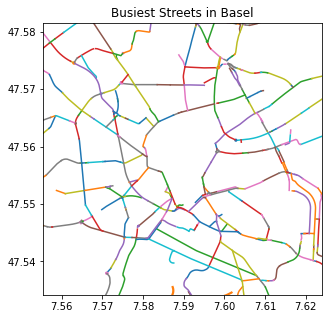

In [27]:
# test
plt.figure(figsize=(5, 5))
plot_streets(rainbow=True)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Busiest Streets in Basel")
plt.show()

### Define a function for plotting measuring stations

In [28]:
def plot_stations(df, col_name, color="Blue", size=10, zorder=0, alpha=1, label="Measuring Stations", marker="o"):
    uni = df[col_name].unique()
    x = []
    y = []
    for point in uni:
        x.append(float(point.split(",")[1]))
        y.append(float(point.split(",")[0]))
    plt.scatter(x, y, label=label, c=color, s=size, zorder=zorder, alpha=alpha, marker=marker)

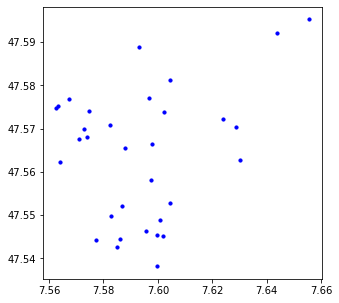

In [29]:
plt.figure(figsize=(5, 5))
plot_stations(verkehr, "Geo Point")
plt.show()

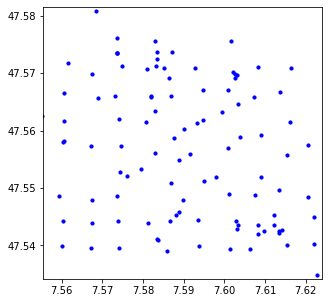

In [30]:
plt.figure(figsize=(5, 5))
plot_stations(luft, "Koordinaten")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

### Define a function for plotting temperature measuring stations

In [31]:
df1.head()

,Unnamed: 0,Station-ID,Name,Zeitstempel,Datum,Stunde,Minute,Koordinaten,Breitengrad,Längengrad,Lufttemperatur,Regen in 1 h,Regen in 24 h,Regen in 48 h
1036034,1036034,0340AD83,Salinenstrasse,2021-05-03 00:00:00+02:00,2021-05-03,0,0,"47.5485535993,7.62721055341",47.548554,7.627211,6.9600,0.0,10.4,31.0
1036035,1036035,03A0B2C9,St. Johann (NBIoT),2021-05-03 00:00:00+02:00,2021-05-03,0,0,"47.56588,7.58206",47.565880,7.582060,8.8100,0.0,11.0,27.0
1036036,1036036,03409983,Marktplatz,2021-05-03 00:00:01+02:00,2021-05-03,0,0,"47.5587,7.58764",47.558700,7.587640,8.5467,0.0,10.8,26.6
1036037,1036037,03409993,Rüdinstrasse,2021-05-03 00:00:10+02:00,2021-05-03,0,0,"47.5713,7.64038",47.571300,7.640380,7.0633,0.0,7.4,23.0
1036038,1036038,03409976,Freiburgerstraße,2021-05-03 00:00:17+02:00,2021-05-03,0,0,"47.6316970101,7.65809634006",47.631697,7.658096,6.2367,0.0,12.0,27.0


### Define a function for plotting vehicles in heat map

In [34]:
def vehicle_grid(df, date, hour, n):
    day = df[(df.Date == date) & (df.TimeFrom == hour)]
    x = day.Longitude.tolist()
    y = day.Latitude.tolist()
    vals = day.Total.tolist()
    
    a = boxes.vals_to_boxes(x, y, vals, x_min, x_max, y_min, y_max , n)   
    return a

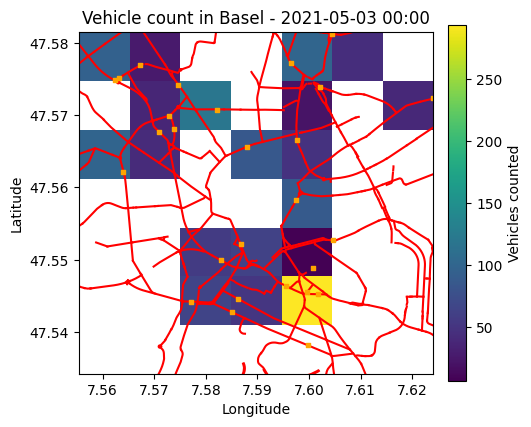

In [108]:
a = vehicle_grid(df2, "2021-05-03", "00:00", 7)
plt.figure(figsize=(5, 5), dpi=100)
plot_streets(zorder=1)
plot_stations(verkehr, "Geo Point", zorder=2, color="Orange", marker=",")
plt.imshow(a, extent=box, aspect=1.4, origin="lower")
plt.colorbar(label="Vehicles counted", fraction=0.046, pad=0.04)
plt.title("Vehicle count in Basel - 2021-05-03 00:00")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Define a function for plotting temperatures in heat map

In [47]:
def temperature_grid(df, date, hour, n):
    day = df[(df.Datum == date) & (df.Stunde == hour)]
    x = day.Längengrad.tolist()
    y = day.Breitengrad.tolist()
    vals = day.Lufttemperatur.tolist()
    
    a = boxes.vals_to_boxes(x, y, vals, x_min, x_max, y_min, y_max, n, avg=True)
    return a

In [68]:
def temp_interpolate(p):
    # normal cubic interpolation (but still has nan values on the edges)
    x = np.arange(0, p.shape[1])
    y = np.arange(0, p.shape[0])
    p = np.ma.masked_invalid(p)   # mask nans with --
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~p.mask]
    y1 = yy[~p.mask]
    newarr = p[~p.mask]
    in_p = griddata((x1, y1), newarr.ravel(),(xx, yy),method='cubic')
    
    return in_p

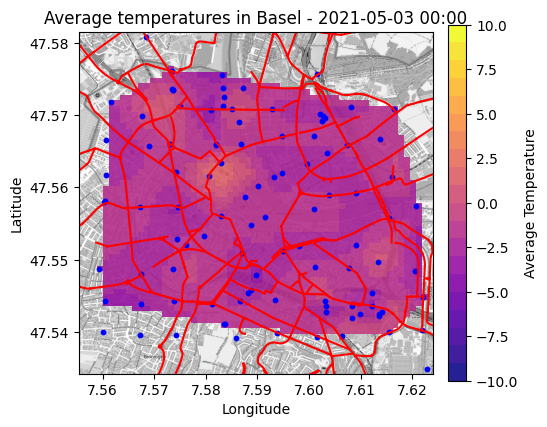

In [103]:
a = temperature_grid(luft, "2021-02-12", 14, 60)
a = temp_interpolate(a)
plt.figure(figsize=(5, 5), dpi=100)
plot_streets(zorder=2)
plot_stations(luft, "Koordinaten", zorder=2)
plt.imshow(a, extent=box, aspect=1.4, origin="lower", cmap=plt.cm.get_cmap('plasma', 20), zorder=1, alpha=.9)
plt.colorbar(label="Average Temperature", fraction=0.046, pad=0.04)
plt.clim((-10, 10))
plt.imshow(basel, extent=box, aspect=1.4, zorder=0)
plt.title("Average temperatures in Basel - 2021-05-03 00:00")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.xlim(7.57, 7.61)
#plt.ylim(47.54, 47.57)
plt.show()

### Define a function for plotting correlation in heat map

In [38]:
# vdf -> verkehr
# tdf -> temperature
def correlation_grid(vdf, tdf, start_date, end_date, n, drop_empty=True):
    # select time frame from data frames
    tdf = tdf[(tdf.Datum >= start_date) & (tdf.Datum <= end_date)]
    vdf = vdf[(vdf.Date >= start_date) & (vdf.Date <= end_date)]
    # due to bad formatting of data
    vdf["hour"] = vdf.DateTimeFrom.apply(lambda x: dt.datetime.fromisoformat(x).hour)
    
    # convert input dates to dt.datetime
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    
    delta_days = (end_date - start_date).days
    a1_lst = []
    a2_lst = []
    
    date = start_date
    for i in range(delta_days):
        for hour in range(24):
    
            now1 = tdf[(tdf.Datum == date.strftime("%Y-%m-%d")) & (tdf.Stunde == hour)]
            x = now1.Längengrad.tolist()
            y = now1.Breitengrad.tolist()
            vals = now1.Lufttemperatur.tolist()
            
            a1 = boxes.vals_to_boxes(x, y, vals, x_min, x_max, y_min, y_max, n, remove_empty=drop_empty, avg=True)
            a1_lst.append(a1)
            
            now2 = vdf[(vdf.Date == date.strftime("%Y-%m-%d")) & (vdf.hour == hour)]
            x = now2.Longitude.tolist()
            y = now2.Latitude.tolist()
            vals = now2.Total.tolist()
            
            a2 = boxes.vals_to_boxes(x, y, vals, x_min, x_max, y_min, y_max, n, remove_empty=drop_empty, avg=True)
            a2_lst.append(a2)
        
        # advance one day
        date += dt.timedelta(days=1)
    
    corr = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            x = []
            for a1 in a1_lst:
                x.append(a1[i][j])
            y = []
            for a2 in a2_lst:
                y.append(a2[i][j])
            
            x = np.array(x)
            y = np.array(y)
            
            corr_mat = np.corrcoef(np.vstack([x, y]))
            corr[i][j] = corr_mat[0][1]
    
    return corr

In [39]:
corr = correlation_grid(verkehr, luft, "2020-07-01", "2020-7-31", 8, drop_empty=False)

/var/folders/8l/ym_82p1n74j5qvyvh0b0tmx00000gn/T/ipykernel_7256/2495263352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdf["hour"] = vdf.DateTimeFrom.apply(lambda x: dt.datetime.fromisoformat(x).hour)
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [75]:
basel = plt.imread("maps/basel_square_bw.jpg")

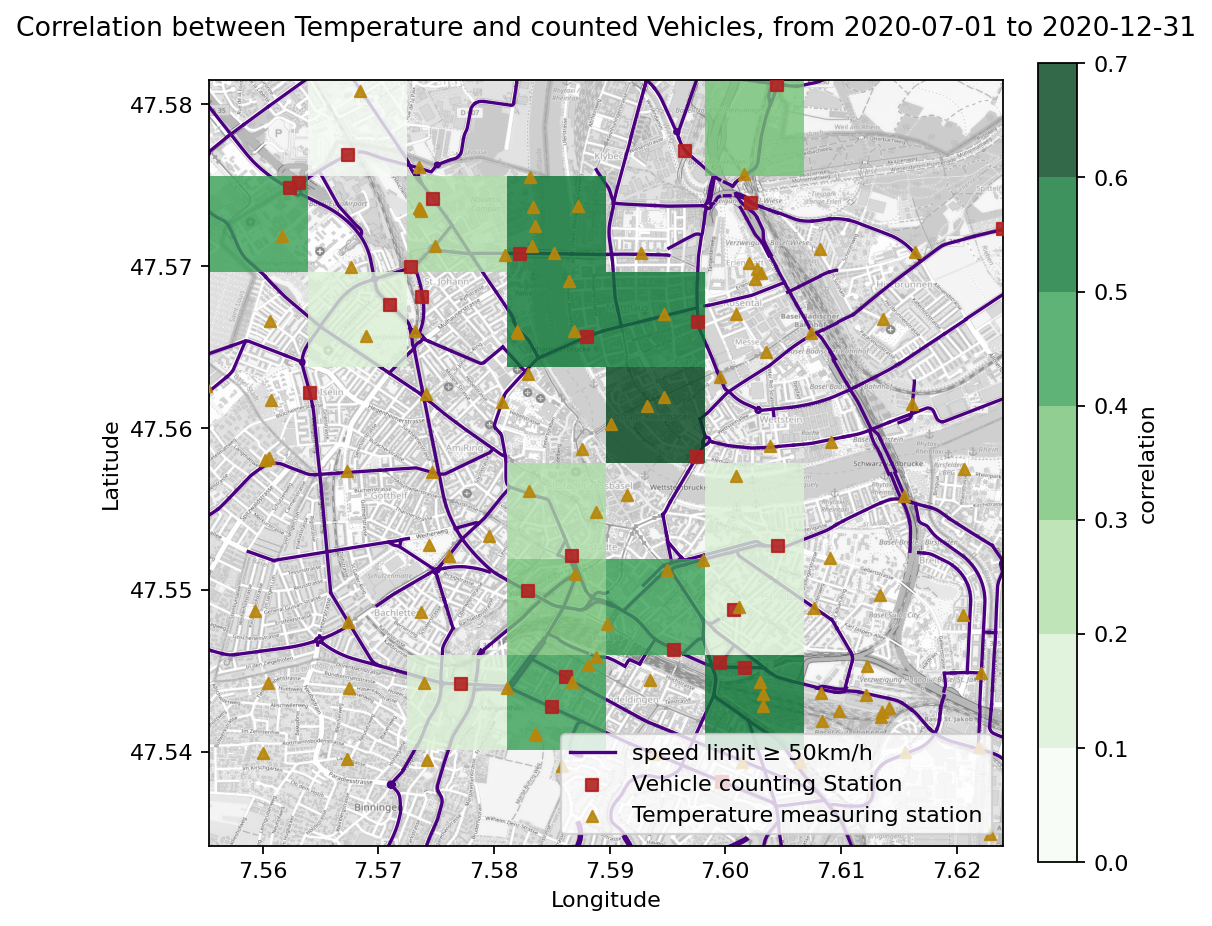

In [56]:
plt.figure(figsize=(7, 7), dpi=160)
plot_streets(zorder=1, color="indigo")
plot_stations(verkehr, "Geo Point", zorder=3, size=25, color="firebrick", alpha=.9, label="Vehicle counting Station", marker=",")
plot_stations(luft, "Koordinaten", zorder=3, size=25, color="darkgoldenrod", alpha=.9, label="Temperature measuring station", marker="^")
plt.imshow(corr, extent=box, aspect=1.4, origin="lower", label="test", zorder=2, alpha=.8, cmap=plt.cm.get_cmap('Greens', 7))
plt.colorbar(label="correlation", fraction=0.046, pad=0.04)
plt.clim((0, .7))
plt.imshow(basel, extent=box, zorder=0, aspect=1.4, alpha=.6)
plt.title("Correlation between Temperature and counted Vehicles, from 2020-07-01 to 2020-12-31", pad=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower right')
plt.show()

In [51]:
strong_corr = np.zeros(corr.shape)
n = len(corr[0])

for i in range(n):
    for j in range(n):
        if corr[i][j] >= .7:
            strong_corr[i][j] = .7
        elif corr[i][j] >= .5:
            strong_corr[i][j] = .5
        elif corr[i][j] >= .3:
            strong_corr[i][j] = .3

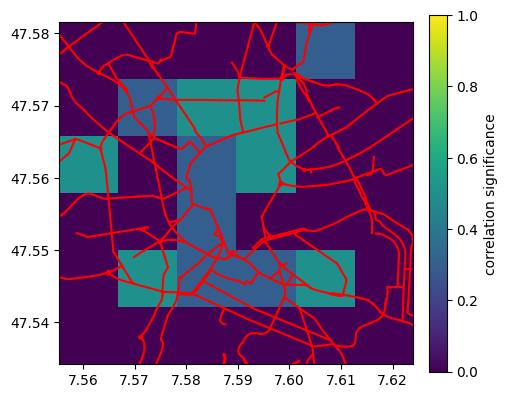

In [52]:
plt.figure(figsize=(5, 5), dpi=100)
plot_streets(zorder=1)
plt.imshow(strong_corr, extent=box, aspect=1.4, origin="lower")
plt.colorbar(label="correlation significance", fraction=0.046, pad=0.04)
plt.clim((0,1))
plt.show()

In [53]:
corr

array([[       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan, 0.50127029, 0.43317628, 0.40426703, 0.57008844,
               nan],
       [       nan,        nan, 0.33685654,        nan, 0.29076334,
               nan],
       [0.53496633,        nan, 0.45913706, 0.61281632,        nan,
               nan],
       [       nan, 0.45374375, 0.56613862, 0.57425486,        nan,
               nan],
       [       nan, 0.10698639,        nan,        nan, 0.38101197,
               nan]])